In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
pd.set_option('display.width',1000)


%matplotlib inline

In [6]:
def get_covid_latest_data():
    resp_history = requests.get('https://api.rootnet.in/covid19-in/stats/history')

    if resp_history.status_code != 200:
        # This means something went wrong.
        raise ApiError('GET /tasks/ {}'.format(resp_history.status_code))

    j = resp_history.json()  
    datatime = j['lastRefreshed']
    data = j['data']
    df = pd.DataFrame([],columns=list('TSCIFARD'))

    for item in data:
        date = item['day']
        r = item['regional']

        df2 = pd.DataFrame([],columns=list('TSCIFARD'))
        for item in r:
            #print(item)
            d = list(item.values())
            #print(d)
            d.insert(0,date)

            myd={}
            myd['T'] = date
            myd['S'] = item['loc']
            myd['C'] = item['confirmedCasesIndian'] + item['confirmedCasesForeign']
            myd['I'] = item['confirmedCasesIndian']
            myd['F'] = item['confirmedCasesForeign']
            myd['A'] = item['confirmedCasesIndian']  + item['confirmedCasesForeign'] - item['discharged'] - item['deaths']
            myd['R'] = item['discharged']
            myd['D'] = item['deaths']
            #print(myd)
            df1 = pd.DataFrame(myd,index=[1])
            df2 = pd.concat((df2,df1))

        myd = dict(zip(list('TSCIFARD'), [date,'India',df2.C.sum(),df2.I.sum(),df2.F.sum(),df2.A.sum(),df2.R.sum(),df2.D.sum()]))   
        dt = pd.DataFrame(myd,index=[1])

        df = pd.concat((df,df2,dt))
        #break

    #print(df.head())
    df.reset_index(inplace=True)
    df.drop(columns=['index'],inplace=True)
    df.set_index(['T'],inplace=True)
    df.index.name=''
    #print(df.head())
    #print(df.tail())
    summary = df.iloc[-1]
    #print(summary)
    #print(type(summary))
    dfard = df[['S','A','R','D']]
    #print(dfard.head())
    #print(dfard.tail())    
    
    return df,datatime

In [7]:
df,datatime = get_covid_latest_data()
print(datatime)

2020-07-02T12:18:32.949Z


In [8]:
print(df.head())
df.loc[df['C'] == 0] = 1
df.loc[:,'R%'] = (df.loc[:,'R'] * 100) / df.loc[:,'C']
df.loc[:,'D%'] = (df.loc[:,'D'] * 100) / df.loc[:,'C']
df.loc[:,'A%'] = (df.loc[:,'A'] * 100) / df.loc[:,'C']
print(df.tail())

                      S   C  I   F   A  R  D
                                            
2020-03-10        Delhi   4  4   0   4  0  0
2020-03-10      Haryana  14  0  14  14  0  0
2020-03-10    Karnataka   1  1   0   1  0  0
2020-03-10       Kerala   9  9   0   9  0  0
2020-03-10  Maharashtra   2  2   0   2  0  0
                        S       C       I   F       A       R      D       R%         D%       A%
                                                                                                 
2020-07-02        Tripura    1396    1396   0     302    1093      1  78.2951  0.0716332  21.6332
2020-07-02    Uttarakhand    2947    2946   1     589    2317     41  78.6223    1.39125  19.9864
2020-07-02  Uttar Pradesh   24056   24055   1    6709   16629    718  69.1262     2.9847  27.8891
2020-07-02    West Bengal   19170   19170   0    5959   12528    683  65.3521    3.56286   31.085
2020-07-02          India  597809  597771  38  220115  359860  17834  60.1965    2.98323  36.8203

In [9]:
def percentage_ard2(df, title_place = 'India', datatime=None,show=True):
    pdf = df.copy()
    pdf = pdf[pdf.S == title_place]
    plt.style.use('fivethirtyeight')
    fig,ax = plt.subplots(nrows=2, ncols=2,figsize=(30,16))
    
    ax0 = ax[1][0]
    ax0.set_title(title_place + '\n Covid-Active-Recovery-Deceased Counters \n ' + str(datatime))    
    ax0.plot(pdf[['A']], label = 'A: '+str(round(pdf.loc[pdf.index[-1],'A'],5)))
    ax0.plot(pdf[['R']], label = 'R: '+str(round(pdf.loc[pdf.index[-1],'R'],5)))
    ax0.plot(pdf[['D']], label = 'D: '+str(round(pdf.loc[pdf.index[-1],'D'],5)))
    ax0.plot(pdf[['C']], label = 'Total: '+str(round(pdf.loc[pdf.index[-1],'C'],5)), linestyle='dotted')    
    xtloc = range(0,len(pdf.index),2)
    xtlabel = pdf.index[::2]
    ax0.set_xticks(xtlabel)
    ax0.set_xticklabels(xtlabel, rotation=90)
    ax0.legend()       
    
    ax1 = ax[1][1]
    ax1.set_title(title_place + '\n Covid-Active-Recovery-Deceased Percentages \n ' + str(datatime))    
    ax1.plot(pdf[['A%']], label = 'A: '+str(round(pdf.loc[pdf.index[-1],'A%'],1))+'% : '+str(round(pdf.loc[pdf.index[-1],'A'],5)))
    ax1.plot(pdf[['R%']], label = 'R: '+str(round(pdf.loc[pdf.index[-1],'R%'],1))+'% : '+str(round(pdf.loc[pdf.index[-1],'R'],5)))
    ax1.plot(pdf[['D%']], label = 'D: '+str(round(pdf.loc[pdf.index[-1],'D%'],1))+'% : '+str(round(pdf.loc[pdf.index[-1],'D'],5)))
    yt = list(np.linspace(0,100,11))
    ax1.set_yticks(yt)
    xtloc = range(0,len(pdf.index),2)
    xtlabel = pdf.index[::2]
    ax1.set_xticks(xtlabel)
    ax1.set_xticklabels(xtlabel, rotation=90)
    ax1.legend()   

########
    hd = pdf.D
    hr = pdf.R
    ha = pdf.A
    ax2 = ax[0][0]
    ax2.set_title(title_place + '\n Covid-Active-Recovery-Deceased Percentages \n ' + str(datatime))    
    ax2.bar(x=pdf.index,height=ha,bottom=hr,label='A',color=(0.8, 0.0, 0.0, 0.2))
    ax2.bar(x=pdf.index,height=hr,bottom=hd,label='R',color=(0.0, 0.8, 0.0, 0.2))
    ax2.bar(x=pdf.index,height=hd, label='D',color=(0.1, 0.1, 0.1, 1))
    xtlabel = pdf.index[::2]
    ax2.set_xticklabels(xtlabel, rotation=90)
    ax2.set_xticks(xtlabel)
    ax2.set_xticklabels(xtlabel, rotation=90)
    ax2.legend()   
    #print(pdf)
    yt_start = pdf.loc[pdf.index[0],'C']
    yt_end = pdf.loc[pdf.index[-1],'C']
    yt_diff = yt_end - yt_start
    #print(yt_start,yt_end, yt_diff)
    #yticks = np.arange(0,yt_end,yt_diff//10)
    yticks = np.linspace(0,yt_end,num=10)
    ax2.set_yticks(yticks)
#########

#########
    
    plt.grid(True)
    plt.tight_layout()
 
    plt.savefig('All_India/'+title_place+'.png',bbox_inches = 'tight')
    if show == False:
        plt.close()
    
    return None

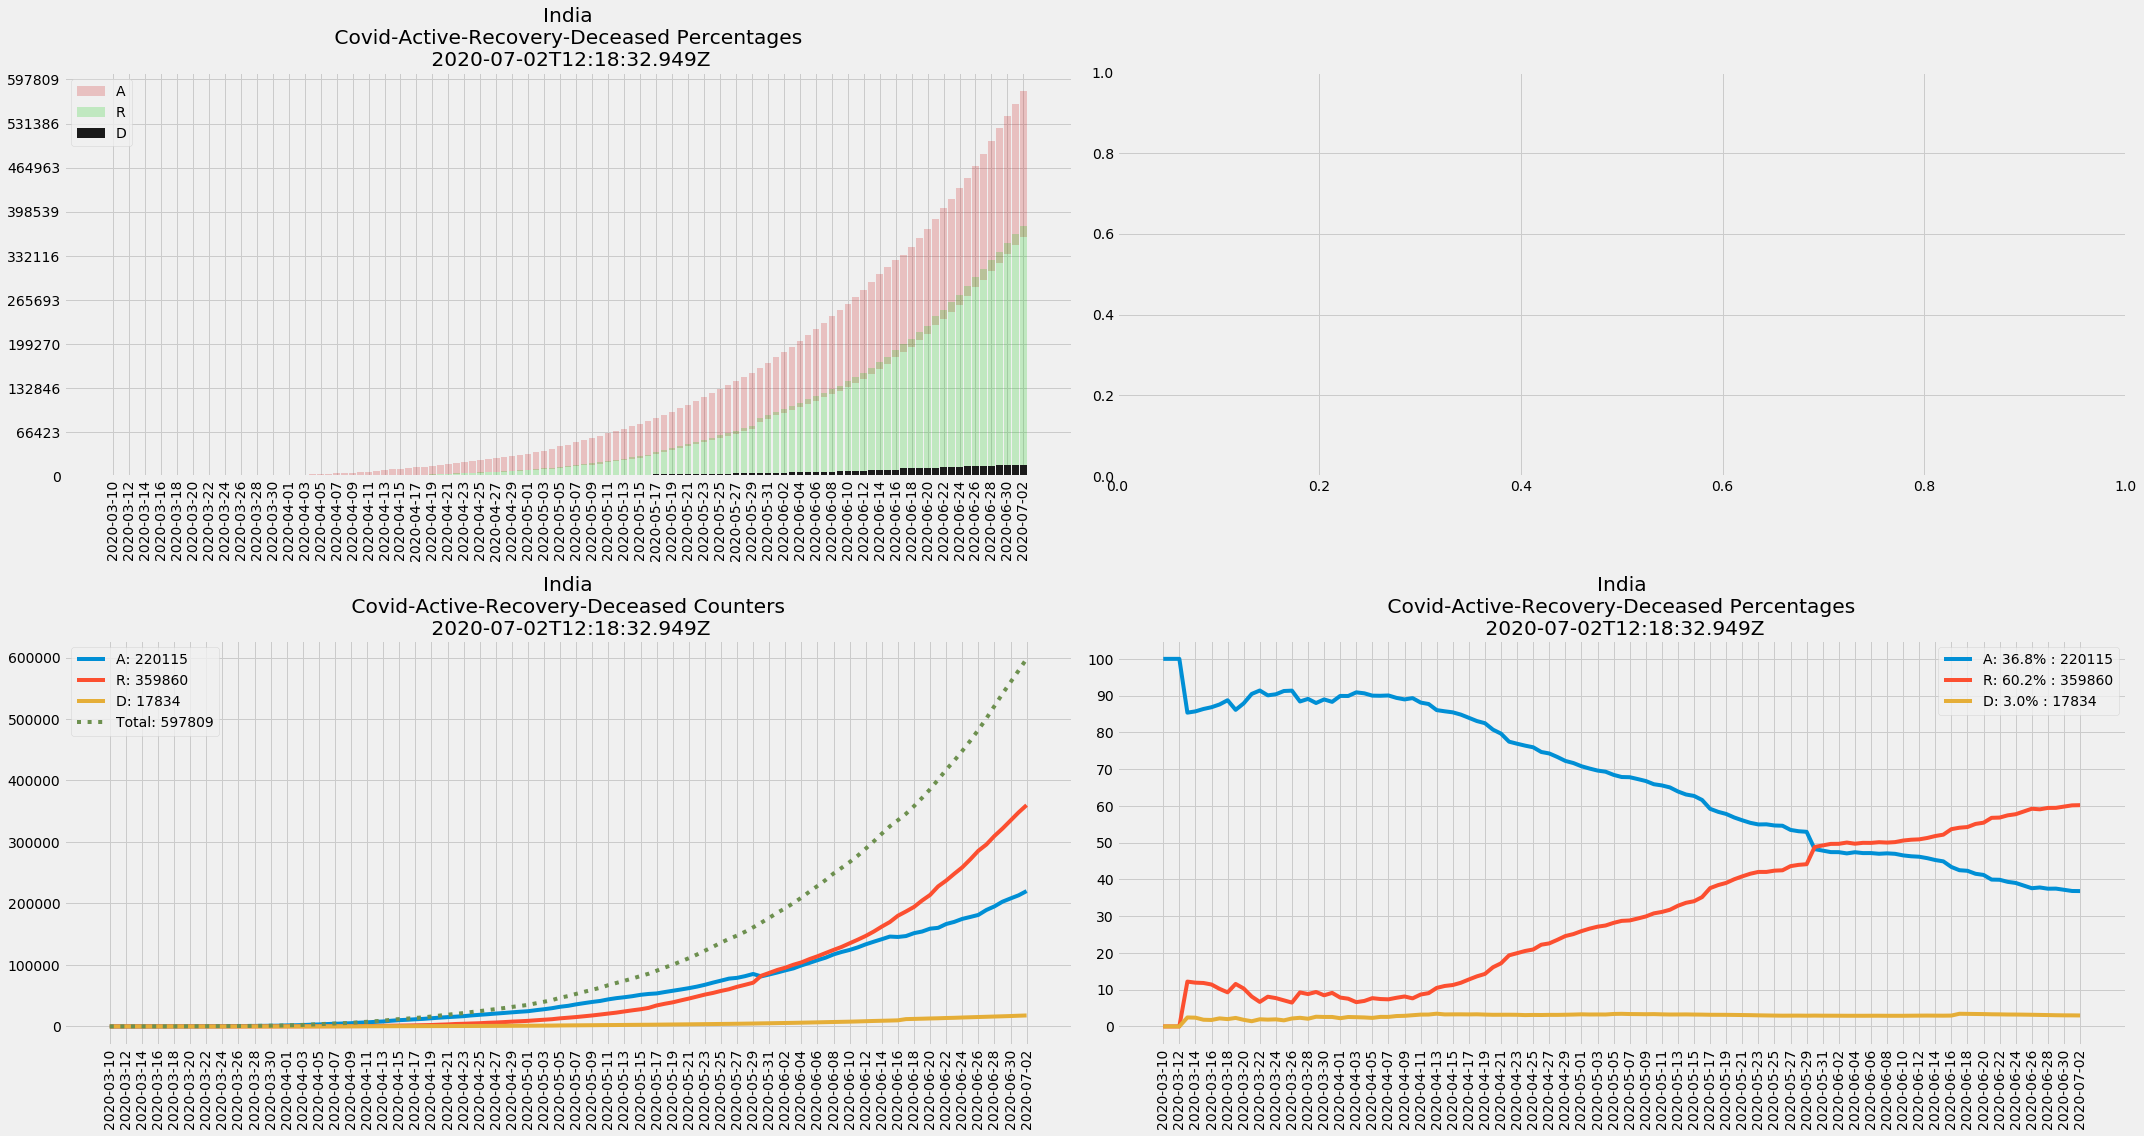

In [10]:
percentage_ard2(df, 'India',datatime=datatime)

In [7]:
statelist = ['Delhi', 'Haryana', 'Karnataka', 'Kerala', 'Maharashtra', 'Punjab', 'Rajasthan', 'Tamil Nadu', 
             'Telengana', 'Jammu and Kashmir', 'Ladakh', 'Uttar Pradesh','Andhra Pradesh', 
             'Uttarakhand', 'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh', 'Chandigarh', 'Gujarat', 
             'Himachal Pradesh', 'Madhya Pradesh', 'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands', 
             'Goa', 'Assam', 'Jharkhand', 'Arunachal Pradesh', 'Tripura', 'Nagaland', 'Meghalaya', 
             'Dadar Nagar Haveli', 'Sikkim', 'India']
print(list(df.S.unique()))
for state in statelist:
        print(state, end= '::')
        percentage_ard2(df[df.S == state],state,show=False,datatime=datatime)

['Delhi', 'Haryana', 'Karnataka', 'Kerala', 'Maharashtra', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Telengana', 'Jammu and Kashmir', 'Ladakh', 'Uttar Pradesh', 'India', 'Andhra Pradesh', 'Uttarakhand', 'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh', 'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh', 'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands', 'Goa', 'Assam', 'Jharkhand', 'Arunachal Pradesh', 'Tripura', 'Nagaland', 'Meghalaya', 1, 'Jharkhand#', 'Madhya Pradesh#', 'Dadar Nagar Haveli', 'Sikkim', 'Dadra and Nagar Haveli and Daman and Diu', 'Telangana']
Delhi::Haryana::Karnataka::Kerala::Maharashtra::Punjab::Rajasthan::Tamil Nadu::Telengana::Jammu and Kashmir::Ladakh::Uttar Pradesh::Andhra Pradesh::Uttarakhand::Odisha::Puducherry::West Bengal::Chhattisgarh::Chandigarh::Gujarat::Himachal Pradesh::Madhya Pradesh::Bihar::Manipur::Mizoram::Andaman and Nicobar Islands::Goa::Assam::Jharkhand::Arunachal Pradesh::Tripura::Nagaland::Meghalaya::Dadar Nagar Haveli::S